# 02 — Bandit OPE Walkthrough

We compare IS, WIS, and Double RL on a synthetic contextual bandit. This
notebook emphasizes diagnostics: overlap, ESS, and weight tails.

## Setup

```
pip install ".[plots]"
```

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from crl.assumptions import AssumptionSet
from crl.assumptions_catalog import OVERLAP, SEQUENTIAL_IGNORABILITY
from crl.benchmarks.bandit_synth import SyntheticBandit, SyntheticBanditConfig
from crl.behavior import BehaviorPolicyFit, behavior_diagnostics, fit_behavior_policy
from crl.estimands.policy_value import PolicyValueEstimand
from crl.estimators.base import DiagnosticsConfig, EstimatorReport, OPEEstimator
from crl.estimators.double_rl import DoubleRLConfig, DoubleRLEstimator
from crl.estimators.importance_sampling import ISEstimator
from crl.ope import evaluate
from crl.utils.seeding import set_seed
from crl.viz import configure_notebook_display, save_figure

In [2]:
set_seed(0)
np.random.seed(0)
configure_notebook_display()

## Run estimators

In [3]:
benchmark = SyntheticBandit(SyntheticBanditConfig(seed=0))
dataset = benchmark.sample(num_samples=1_000, seed=1)
true_value = benchmark.true_policy_value(benchmark.target_policy)

estimand = PolicyValueEstimand(
    policy=benchmark.target_policy,
    discount=1.0,
    horizon=1,
    assumptions=AssumptionSet([SEQUENTIAL_IGNORABILITY, OVERLAP]),
)

report = evaluate(
    dataset=dataset,
    policy=benchmark.target_policy,
    estimators=["is", "wis", "double_rl"],
)
summary = report.summary_table()
summary

,value,stderr,ci,diagnostics,assumptions_checked,assumptions_flagged,warnings,metadata,lower_bound,upper_bound,estimator
0,-0.393095,0.038707,"(-0.4689600359090516, -0.3172303957405684)",{'overlap': {'min_behavior_prob': 0.1097201314...,"[sequential_ignorability, overlap]",[],[],"{'estimator': 'IS', 'num_samples': 1000, 'requ...",-0.468960,-0.317230,IS
1,-0.396854,0.042185,"(-0.47953558159888593, -0.3141718825523601)",{'overlap': {'min_behavior_prob': 0.1097201314...,"[sequential_ignorability, overlap]",[],[],"{'estimator': 'WIS', 'num_samples': 1000, 'req...",-0.479536,-0.314172,WIS
2,-0.423104,0.030082,"(-0.48206487086077743, -0.36414260107394003)",{'overlap': {'min_behavior_prob': 0.1097201314...,"[sequential_ignorability, overlap]",[],[],"{'estimator': 'DoubleRL', 'config': {'num_fold...",-0.482065,-0.364143,DoubleRL


## Estimate behavior propensities

When propensities are missing, you can estimate a behavior policy from logged
data. The helper returns both propensities and diagnostics.

In [ ]:
behavior_fit = fit_behavior_policy(
    dataset, method="logit", seed=0, store_action_probs=True
)
behavior_fit.diagnostics, isinstance(behavior_fit, BehaviorPolicyFit)

In [ ]:
extra_diag = behavior_diagnostics(
    behavior_fit.metadata["action_probs"], dataset.actions, behavior_fit.propensities
)
extra_diag["propensity"]

In [ ]:
dataset_est = behavior_fit.apply(dataset)
dataset_est.describe()

In [ ]:
print(
    summary[["estimator", "value", "lower_bound", "upper_bound"]]
    .round(3)
    .to_string(index=False)
)
best = summary.sort_values("stderr").iloc[0]
print(f"Lowest stderr: {best['estimator']} (stderr={best['stderr']:.4f})")

## Custom estimator configuration

You can tune estimator hyperparameters and diagnostics behavior explicitly.

In [ ]:
double_rl_config = DoubleRLConfig(num_folds=3, ridge=1e-2, seed=0)
double_rl_report = DoubleRLEstimator(estimand, config=double_rl_config).estimate(
    dataset
)

clipped_cfg = DiagnosticsConfig(max_weight=10.0)
is_clipped = ISEstimator(estimand, diagnostics_config=clipped_cfg).estimate(dataset)

(
    double_rl_report.to_dataframe(),
    is_clipped.to_dataframe(),
    isinstance(ISEstimator(estimand), OPEEstimator),
    isinstance(is_clipped, EstimatorReport),
)

## Diagnostics and plots

We'll plot estimator comparisons and inspect weight distributions.

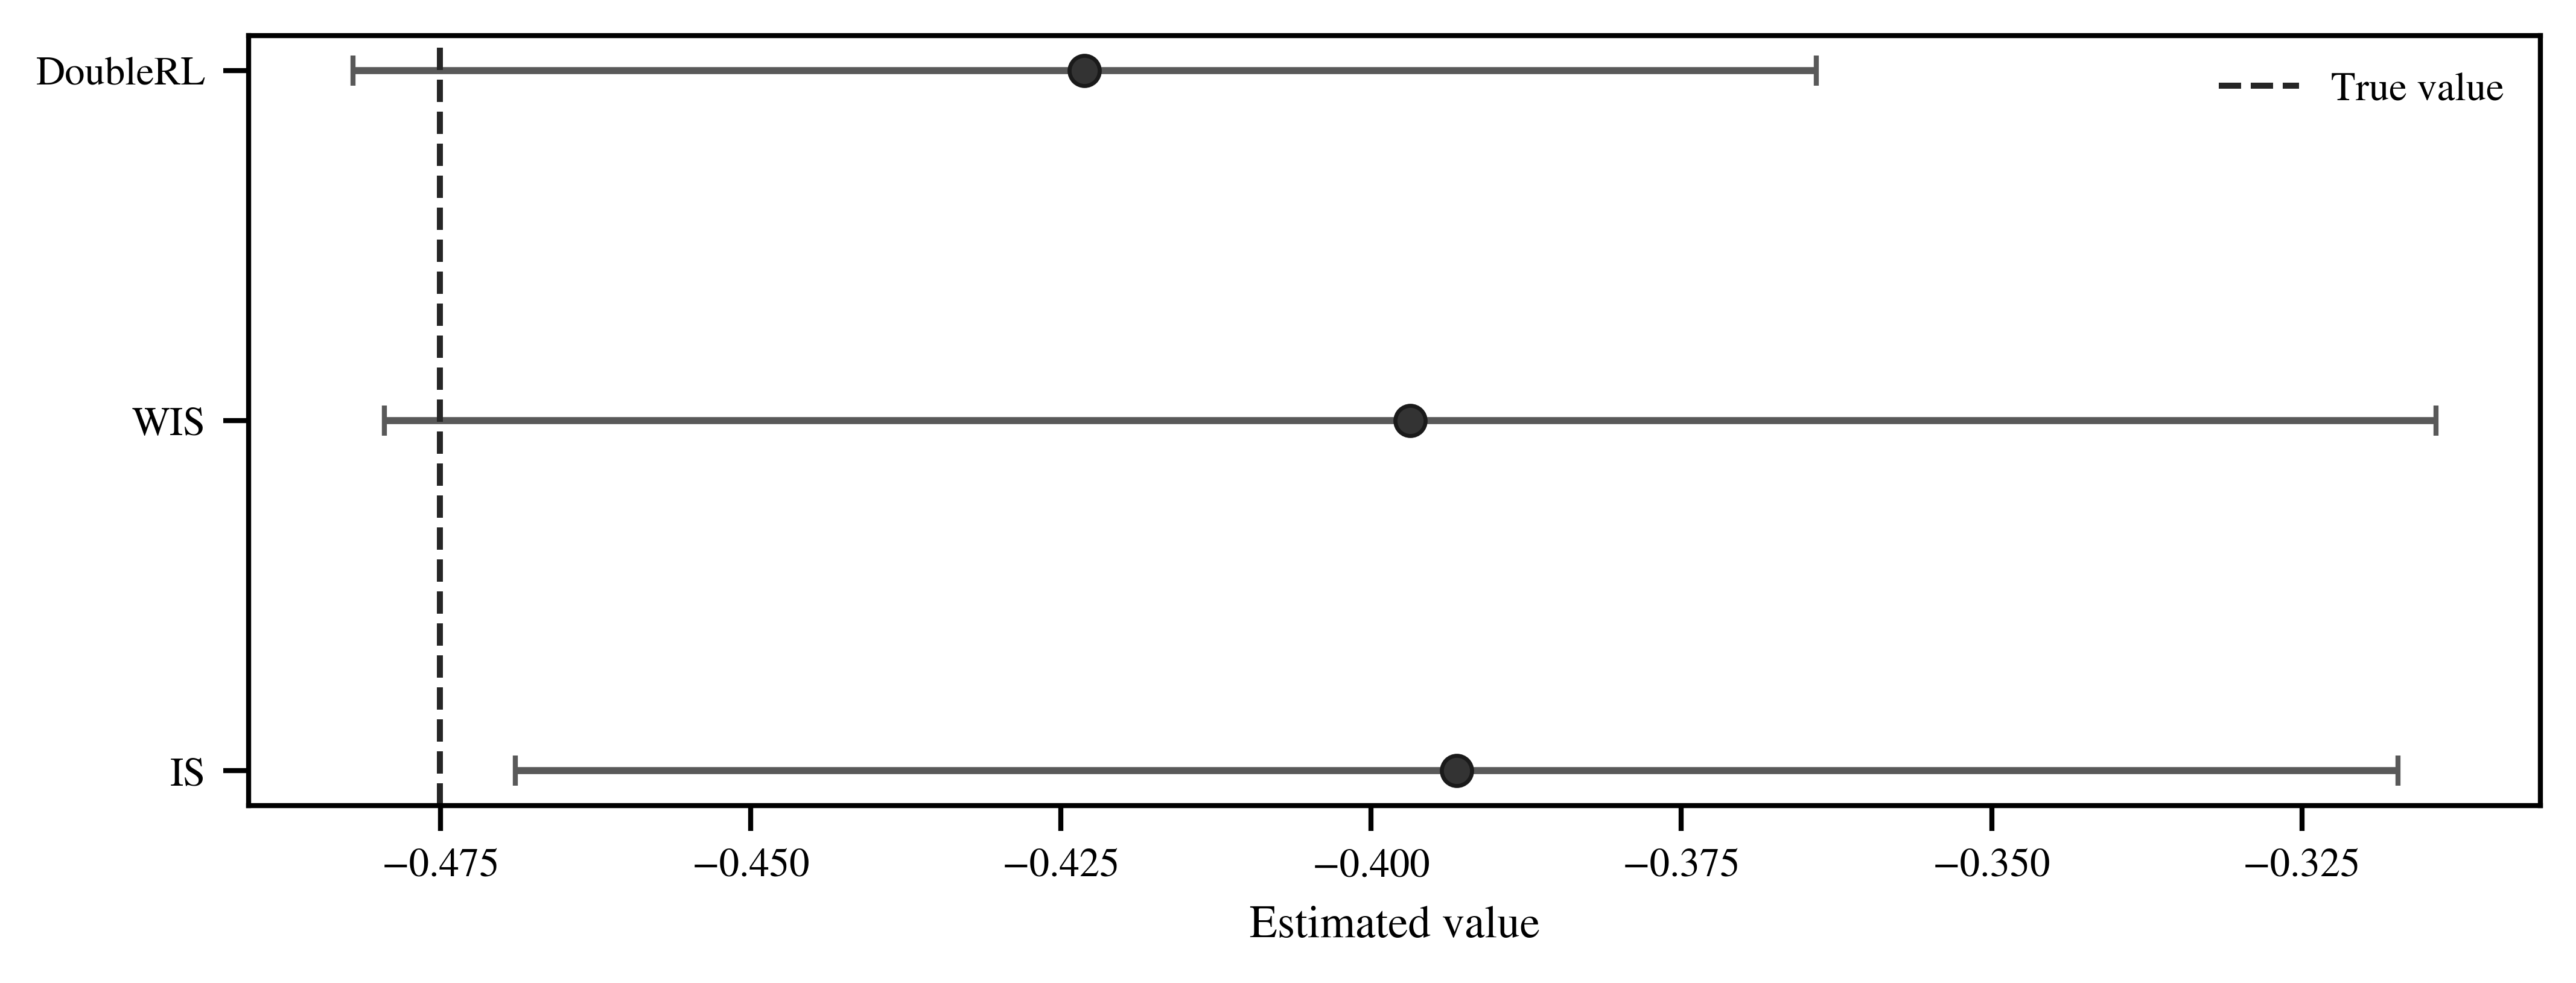

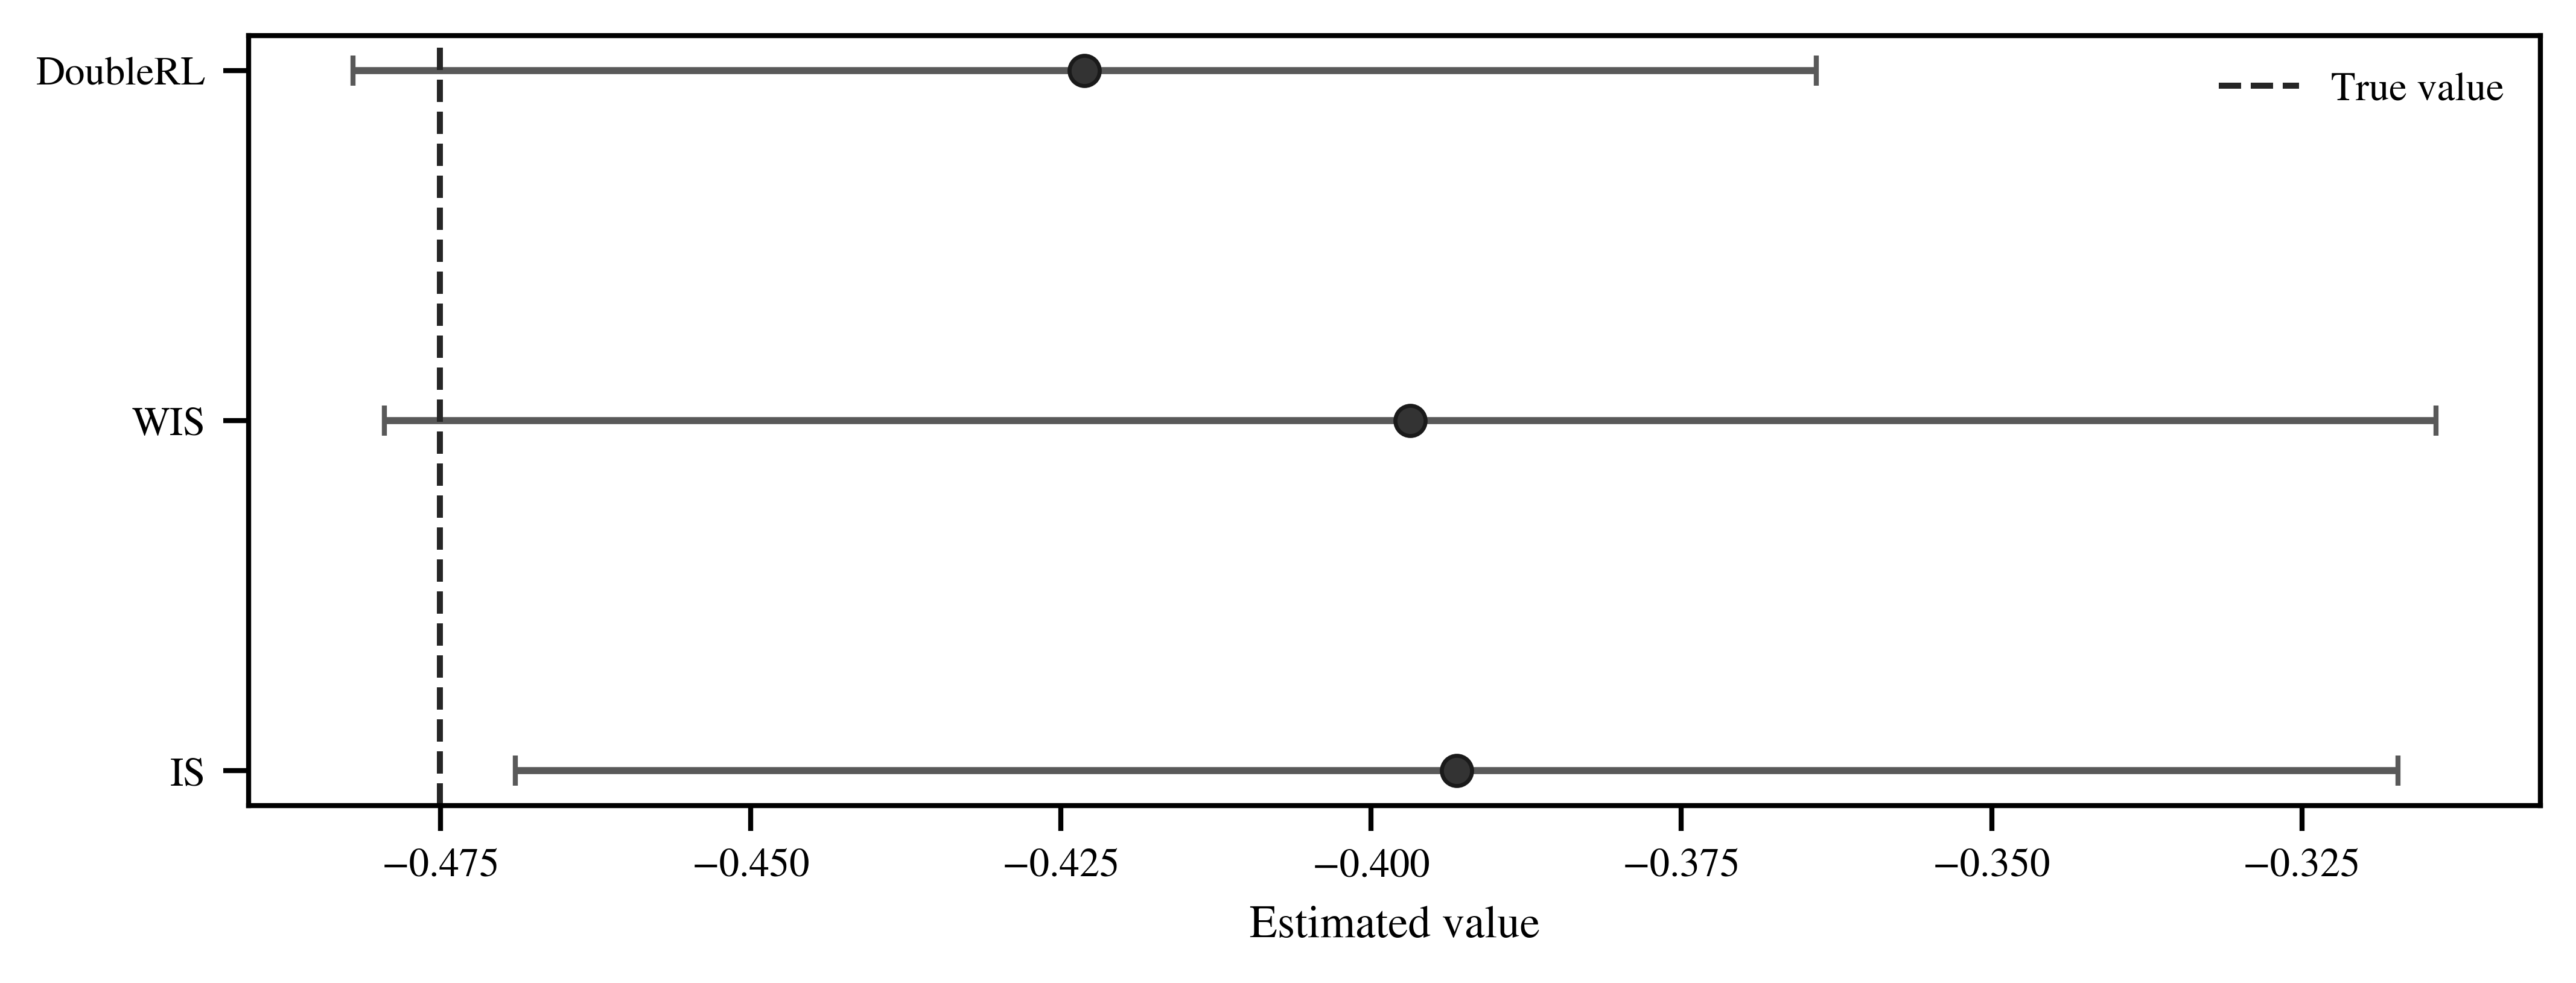

In [4]:
fig = report.plot_estimator_comparison(truth=true_value)
fig

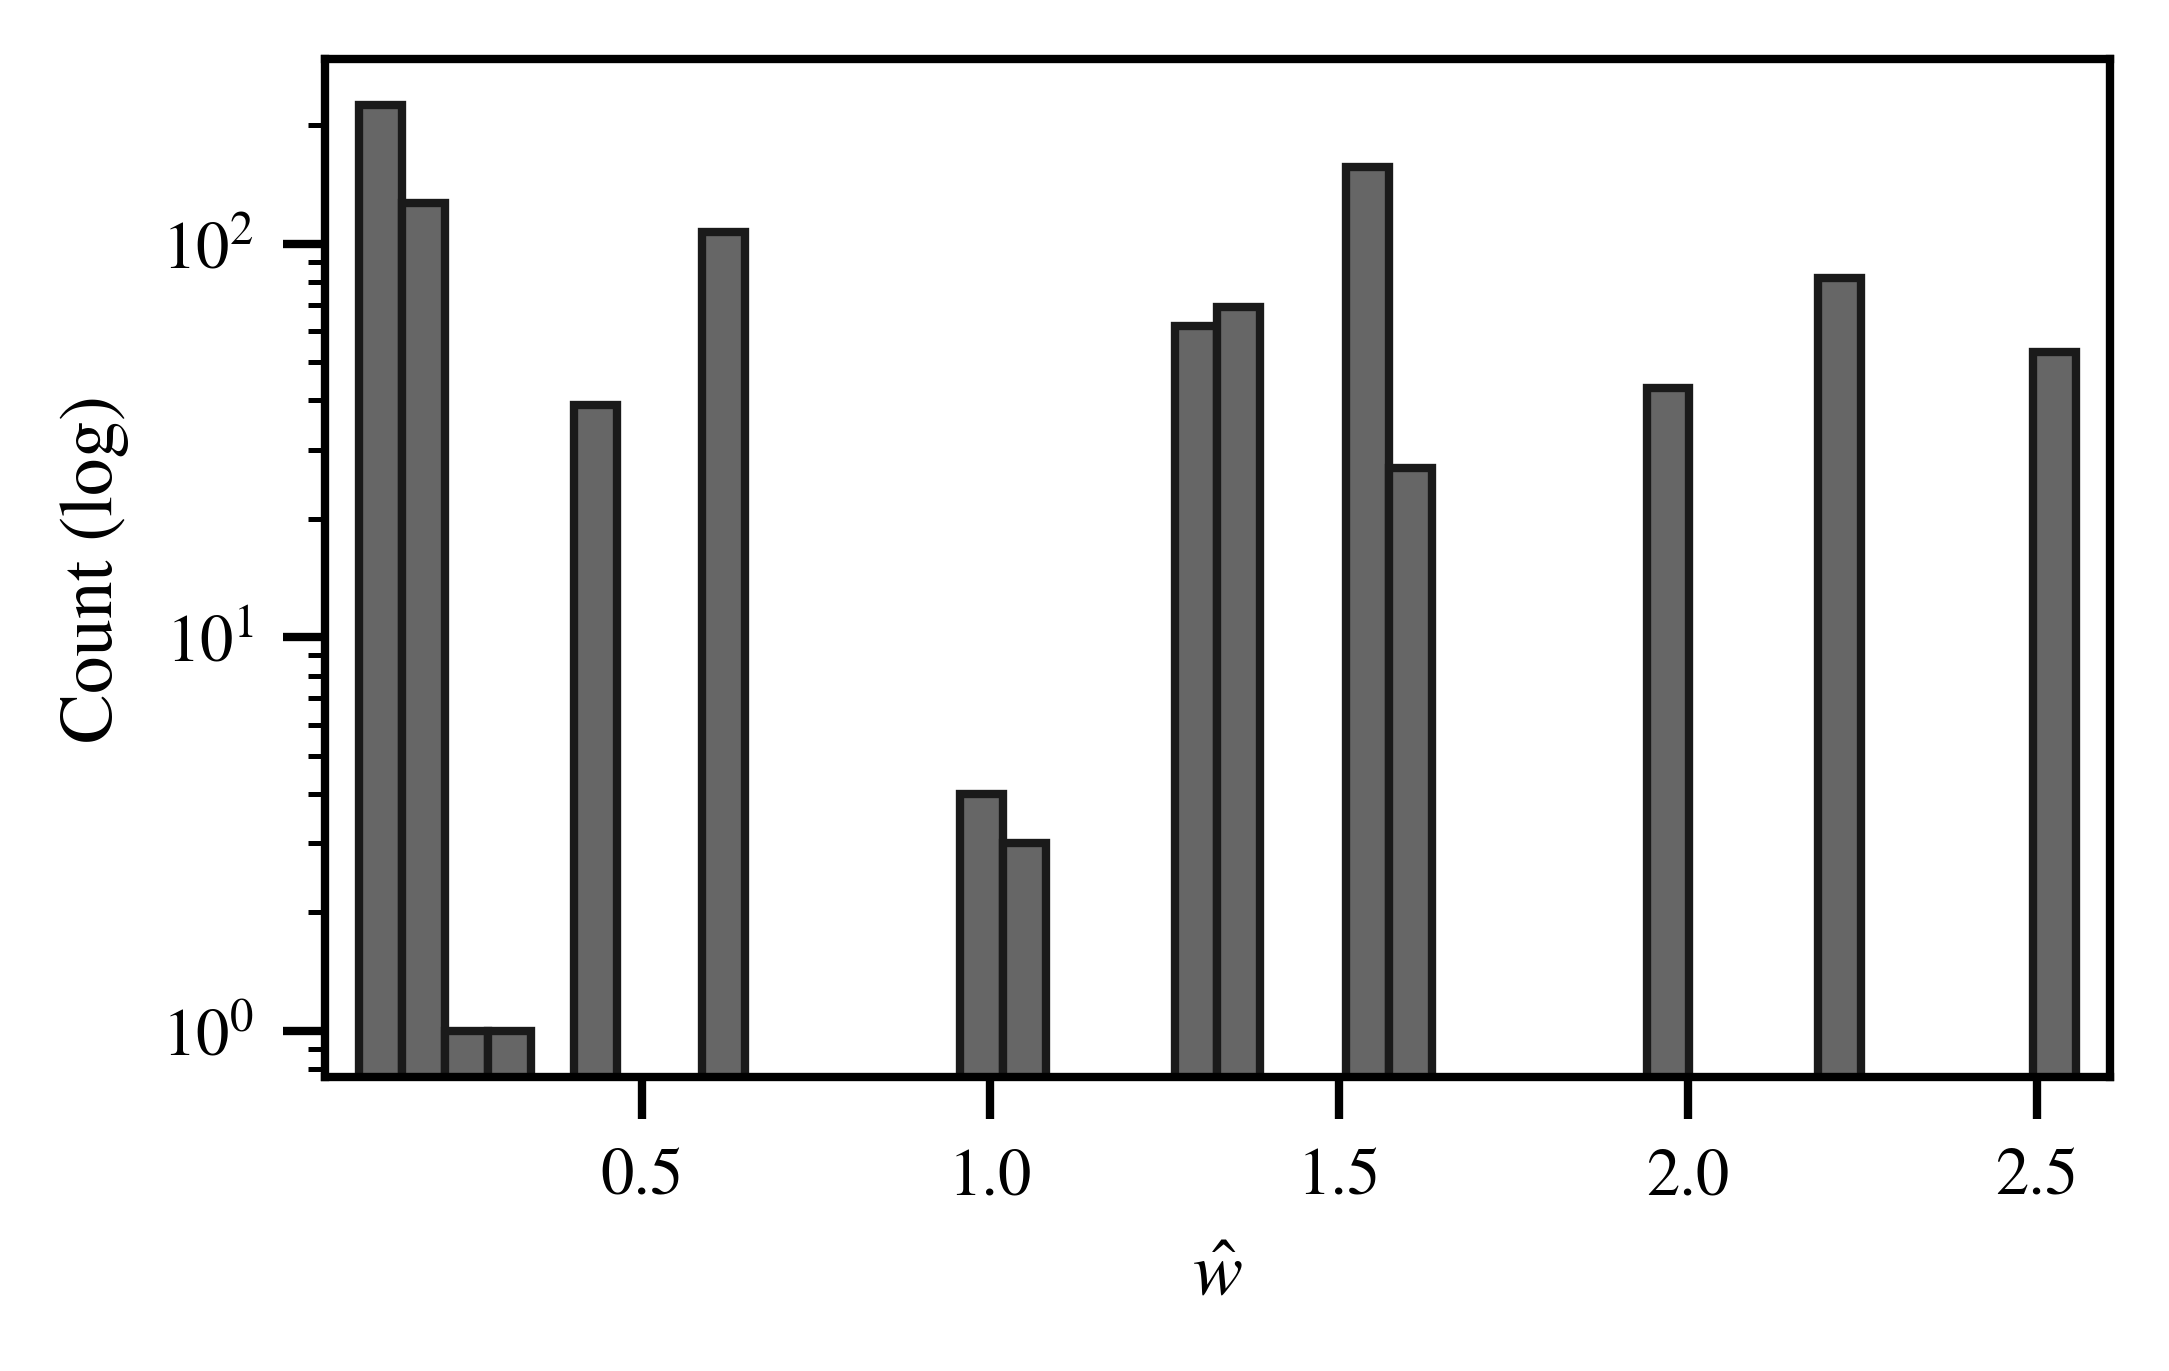

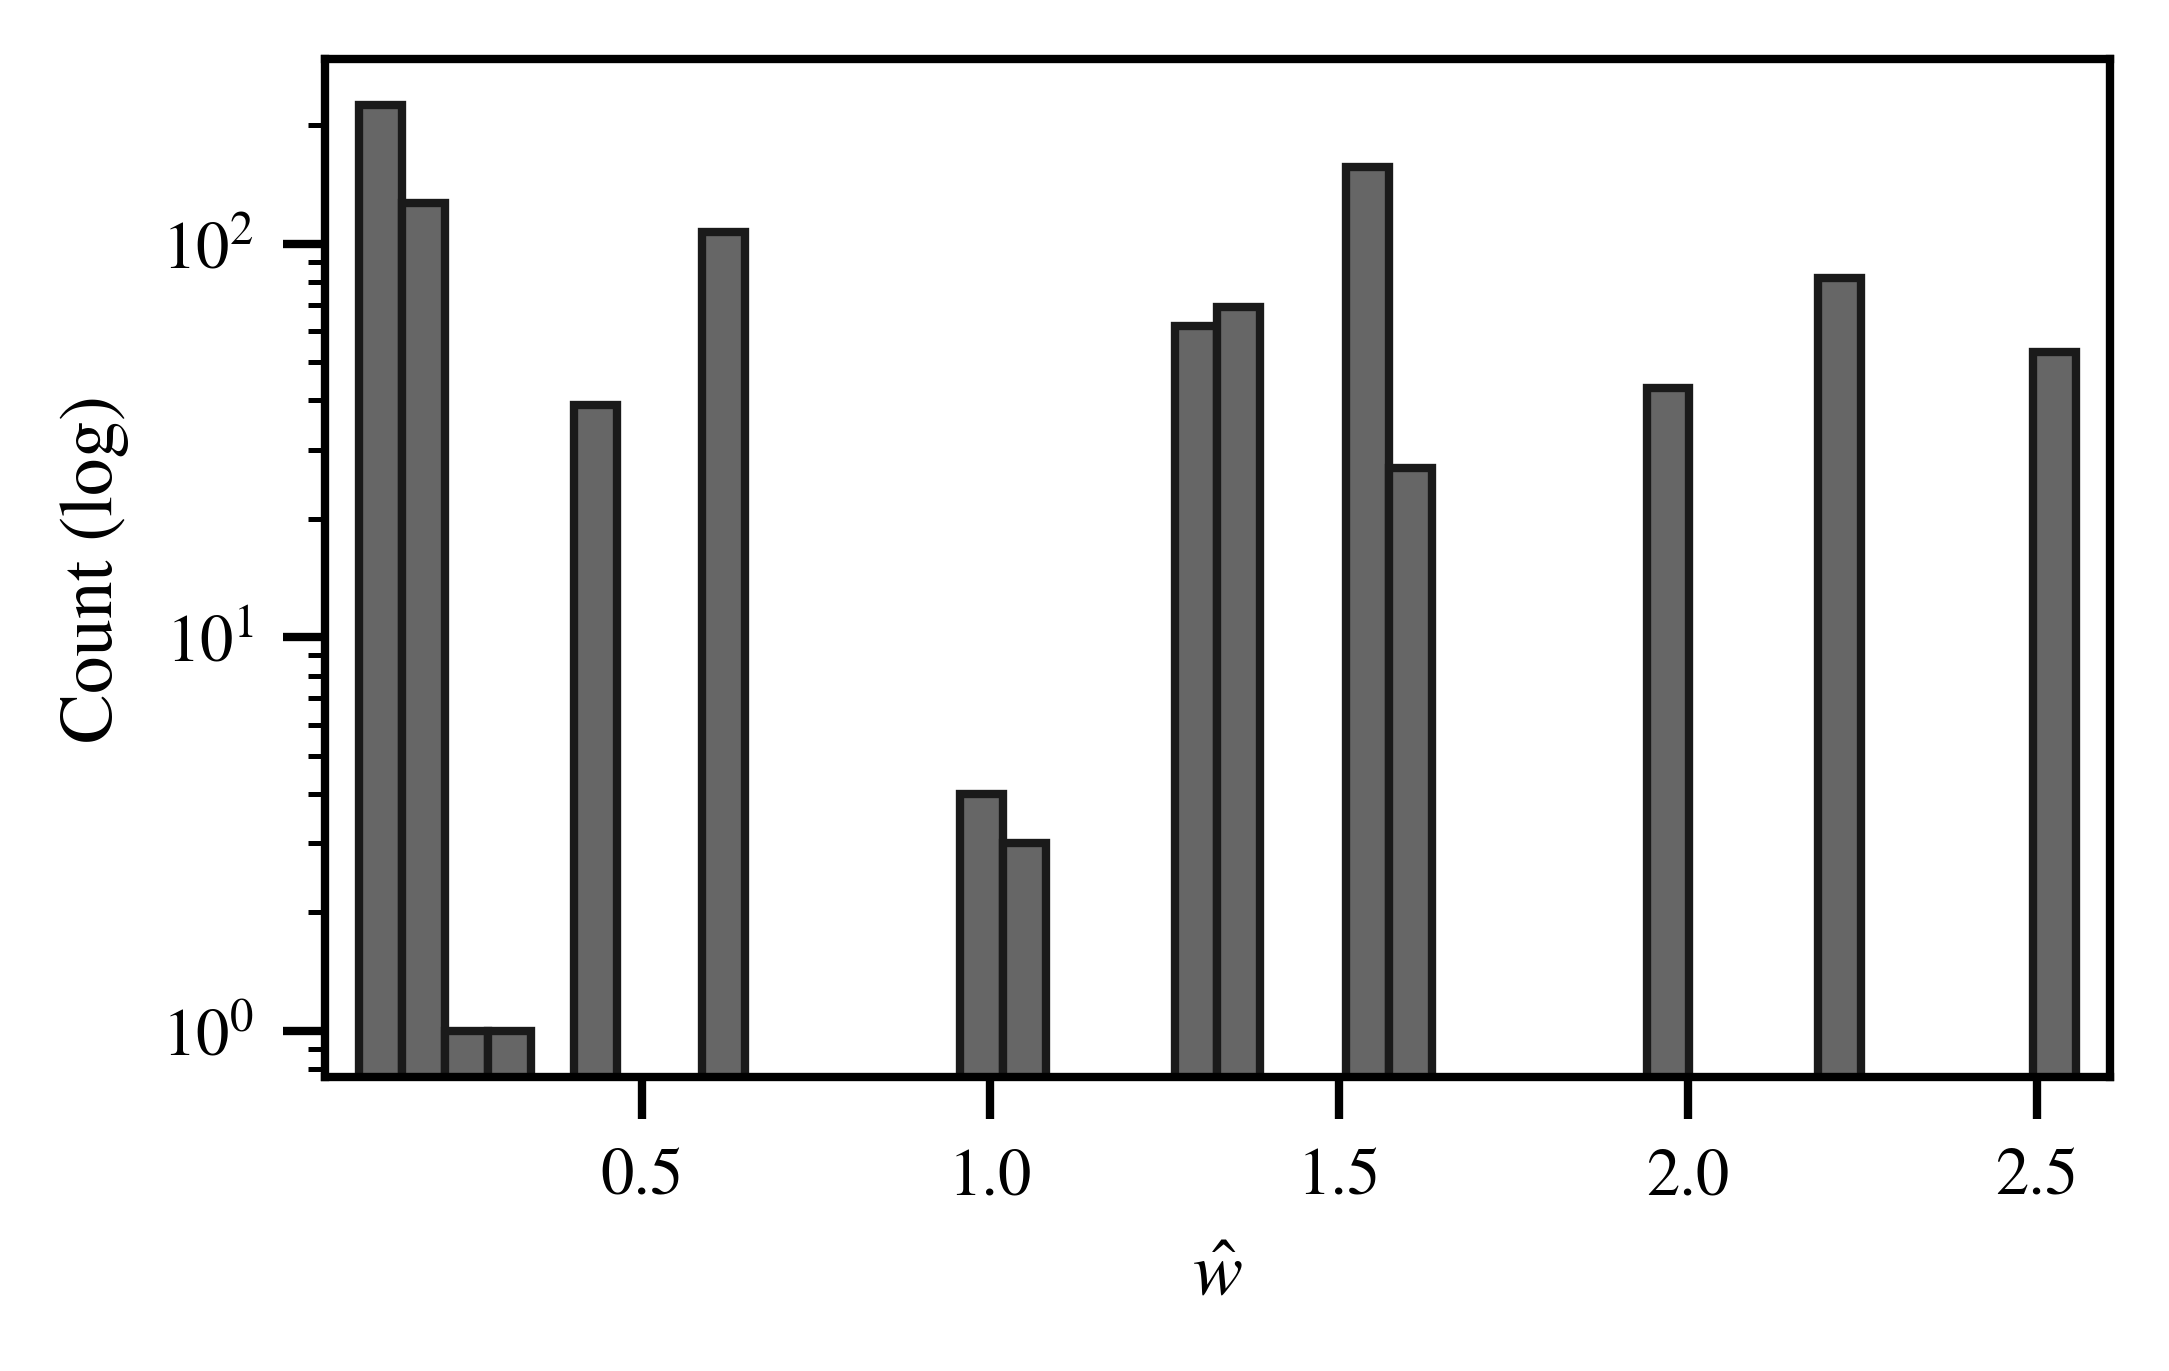

In [5]:
weights = (
    benchmark.target_policy.action_prob(dataset.contexts, dataset.actions)
    / dataset.behavior_action_probs
)
fig_w = report.plot_importance_weights(weights, logy=True)
fig_w

## Save figures

These files are used in the docs site.

In [6]:
output_dir = Path("docs/assets/figures")
output_dir.mkdir(parents=True, exist_ok=True)
save_figure(fig, output_dir / "bandit_walkthrough_estimator_comparison")
save_figure(fig_w, output_dir / "bandit_walkthrough_weights")

{'pdf': 'docs/assets/figures/bandit_walkthrough_weights.pdf',
 'png': 'docs/assets/figures/bandit_walkthrough_weights.png'}

## Takeaways

- IS is unbiased but can be high variance.
- WIS normalizes weights to reduce variance, at the cost of bias.
- Diagnostics (ESS, overlap, tails) tell you when to trust estimates.